In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


# Projeto 4 - Sinais e Sistemas em Tempo Discreto - 2023/01
# Identificação
## Nome: Arthur Henrique Silva Carvalho
## Matrícula: 211026673

# Funções utilizadas.

Coloque abaixo as funções desenvolvidas para este projeto.

In [2]:
def plot_freq_response(x_mag: np.ndarray, x_phase: np.ndarray, name: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), layout='constrained')
    plt.setp(ax[:], xlabel='Frequência angular ($\omega$)')
    plt.setp(ax[0], ylabel='Magnitude')
    plt.setp(ax[1], ylabel='Fase (Graus)')
    ax[0].plot(x_mag)
    plt.setp(ax[0], title=f'Espectro de Magnitude ({name}[$\omega$])')
    ax[1].plot(x_phase)
    plt.setp(ax[1], title=f'Espectro de Fase ({name}[$\omega$])')
    plt.show()



# Questão 1

Considere um sinal $x\left[n\right]$ com 16 amostras:

$$
x\left[n\right] = \left\{ 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 1\right\}
$$


## Questão 1a (1.0 ponto)

Calcule a DFT do sinal através da equação:

$$
X\left[k\right] = \sum_{n = 0}^{N-1} x\left[n\right] W_{N}^{kn}
$$

com $W_{N} = e^{-\frac{2 \pi}{N}}$.

In [3]:
signal = np.array([1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 1])

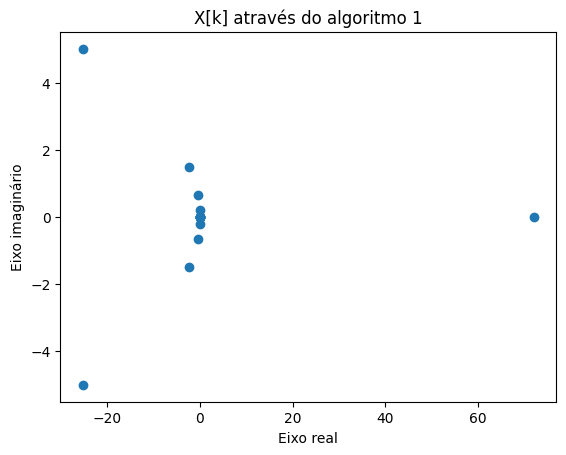

In [4]:
def dft(x: np.ndarray) -> np.ndarray:
    length = len(x)
    w_n = 2*np.pi/length
    response = np.zeros(length, dtype=complex)
    for i in range(length):
        for j in range(length):
            response[i] += x[j] * np.exp(-1j * i * j * w_n)
    return response


x_k = dft(signal)
plt.scatter(x_k.real, x_k.imag)
plt.title('X[k] através do algoritmo 1')
plt.ylabel('Eixo imaginário')
plt.xlabel('Eixo real')
plt.show()


## Questão 1b (1.0 ponto)

Considere a separação do sinal $x\left[n\right]$ em suas amostras pares e ímpares, $x_e\left[n\right]$ e $x_o\left[n\right]$, respectivamente. 

Calcule a DFT do sinal $x\left[n\right]$ através da equação:

$$
\hat{X}\left[k\right] = X_e\left[k\right] + W_{N}^{k} X_o\left[k\right]
$$

Compare as duas DFTs e calcule o erro médio absoluto (MAE) entre as DFTs calculadas pelas duas formas:

$$
MAE = \sum_{i = 0}^{N-1} \left| X\left[i\right] - \hat{X}\left[i\right]\right|
$$

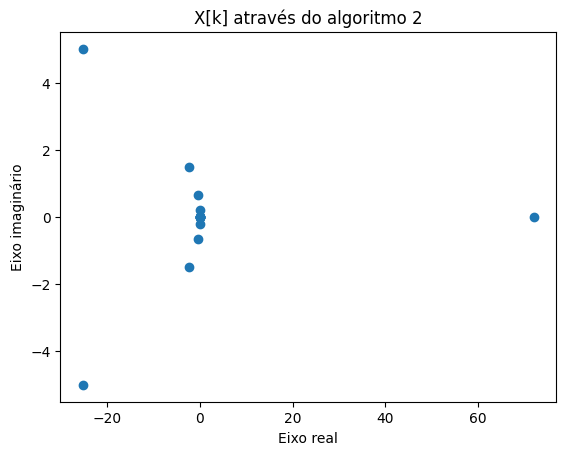

In [5]:
def dft2(x: np.ndarray) -> np.ndarray:
    N = len(x)
    if N <= 1:
        return x
    even = dft2(x[0::2])
    odd  = dft2(x[1::2])
    factor = np.exp(-2j * np.pi * np.arange(N) / N)
    first_half  = even + factor[:N//2] * odd
    second_half = even + factor[N//2:] * odd
    return np.concatenate([first_half, second_half])


x_k_2 = dft2(signal)
plt.scatter(x_k.real, x_k.imag)
plt.title('X[k] através do algoritmo 2')
plt.ylabel('Eixo imaginário')
plt.xlabel('Eixo real')
plt.show()


In [6]:
def calculate_mae(x1: np.ndarray, x2: np.ndarray) -> float:
    mae = 0
    for i in range(len(x1)):
        mae += abs(x1[i]-x2[i])
    return mae


mae = calculate_mae(x_k, x_k_2)
print('MAE =', mae)

MAE = 3.9428489203025274e-13


# Questão 2

O arquivo "potencia.txt" contém dados da envoltória real de um tom senoidal amostrado a uma taxa de $200$ amostras / segundo. Para a separação do desvanecimento em larga escala é necessário filtrar esse sinal com um filtro passa-baixas com frequência de corte em torno de $5$ Hz.


## Questão 2a (1.0  ponto)

Projete um filtro digital com a especificação desejada. Podem ser utilizadas as funções de design de filtro da PySDR (https://pysdr.org/content/filters.html), da própria biblioteca scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) ou mesmo bibliotecas web (http://t-filter.engineerjs.com/) . Plote a resposta em frequência e a resposta ao impulso do filtro projetado. 

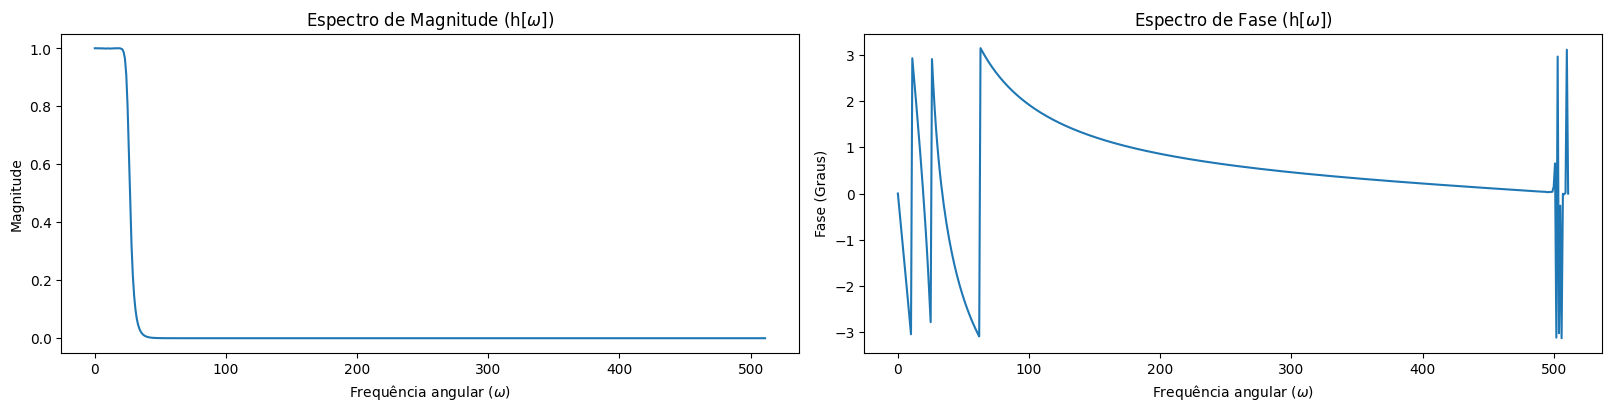

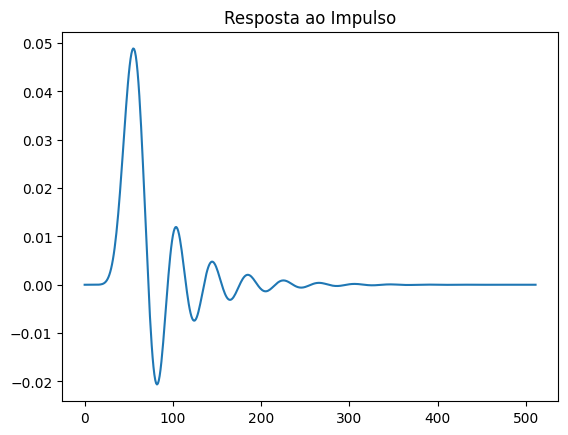

In [7]:
b, a = sp.signal.butter(N=12, Wn=5, fs=200, btype='lowpass')
w, response = sp.signal.freqz(b, a)
h_mag = abs(response)
h_freq = np.angle(response)
plot_freq_response(h_mag, h_freq, 'h')
impulse = np.zeros(512)
impulse[0] = 1
impulse_response = sp.signal.lfilter(b, a, impulse)
plt.plot(impulse_response)
plt.title('Resposta ao Impulso')
plt.show()


Foi projetado um filtro passa-baixas, a função *butter* do *SciPy* foi usada para isso. As variáveis usadas foram:
- $N=12$: ordem do filtro
- $Wn=5$: frequência de corte
- $fs=200$: taxa de amostragem
- *btype='lowpass'*: tipo de filtro

## Questão 2b (1.0 ponto)

Escreva uma função para processar uma janela de $N$ amostras do sinal desejado. $N$ deve ser escolhido em torno de 1 segundo de sinal, aproximadamente. A filtragem deve ser feita no domínio da DFT (pode ser utilizada alguma função para cálculo da fft em Python, como a função fft da biblioteca numpy).

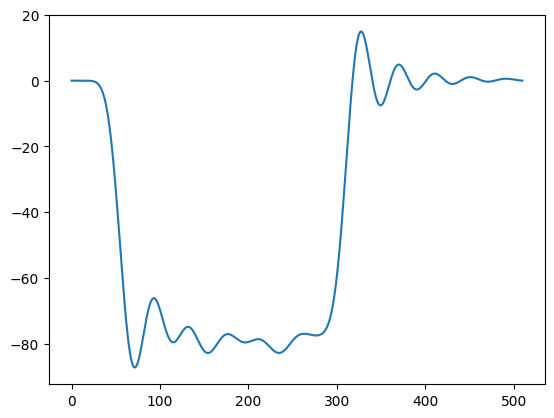

In [8]:
def process_window(signal, kernel):
    fft_length = len(signal) + len(kernel) - 1
    signal_fft = np.fft.fft(signal, fft_length)
    kernel_fft = np.fft.fft(kernel, fft_length)
    convolution = np.fft.ifft(signal_fft * kernel_fft)
    return np.real(convolution)


N = 256
x = np.zeros(N)
x[0] = 1
h_n = sp.signal.lfilter(b, a, x)
signal = np.loadtxt("potencia.txt")
window = signal[:N]
processed_window = process_window(window, h_n)
plt.plot(processed_window)
plt.show()


## Questão 2c (1.0  ponto)

Escreva uma função para combinar a saída do processamento de cada janela na saída do sistema, utilizando **um** dos métodos vistos (*overlap and add* ou *overlap and save*). Indique claramente o método escolhido.


In [9]:

def overlap_add(signal: np.ndarray, h_n: np.ndarray, N: int) -> np.ndarray:
    response = np.zeros(len(signal) + len(h_n) - 1)
    slices = [signal[i : i+N] for i in range(0, len(signal), N)]
    for i in range(len(slices)):
        y = process_window(slices[i], h_n)
        response[i*N : i*N + len(y)] += y
    return response


overlap_add_response = overlap_add(signal, h_n, N)


## Questão 2d (1.0  ponto)

Plote o sinal de entrada e saída do sistema dado tanto pelo processamento em janelas como pelo processamento do sinal completo. Pode ser utilizada alguma função da biblioteca do python para calcular a saída do sistema usando o sinal completo.

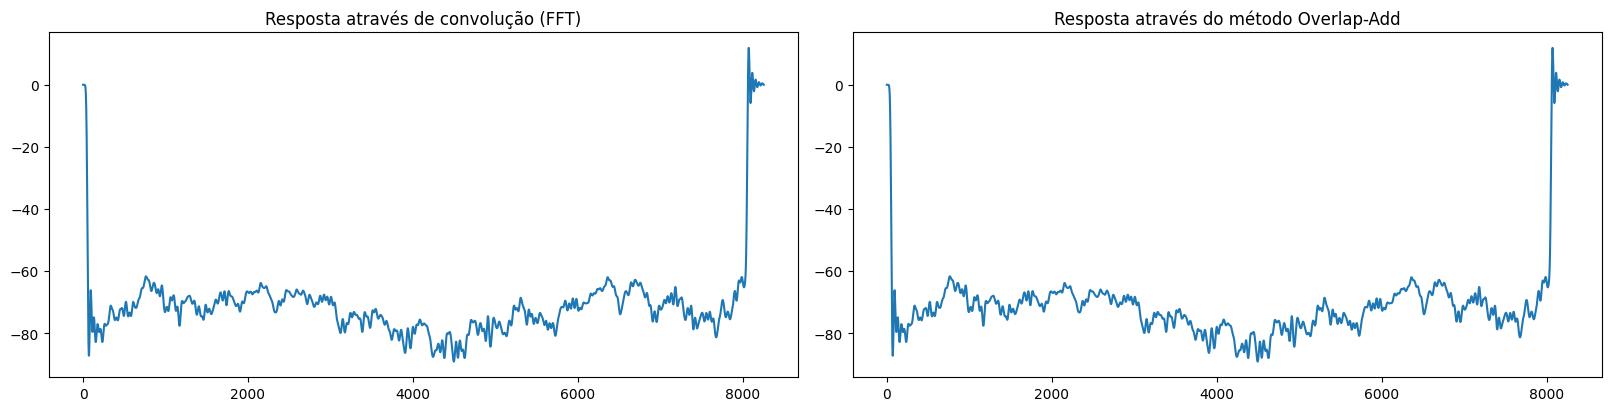

In [10]:
full_convolution_response = sp.signal.fftconvolve(signal, h_n)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), layout='constrained')
ax[0].plot(full_convolution_response)
plt.setp(ax[0], title='Resposta através de convolução (FFT)')
ax[1].plot(overlap_add_response)
plt.setp(ax[1], title='Resposta através do método Overlap-Add')
plt.show()


Através do método *Overlap-Add*, observamos o processamento por janelas resultou em um gráfico idêntico ao do processamento do sinal completo, como era esperado.

# Questão 3

A equação diferença para um filtro FIR de tamanho $N$ pode ser escrita como:

$$
\begin{align}
	y\left[n\right] &= h_0 x\left[n\right] + h_1 x\left[n-1\right] + h_2 x\left[n-2\right] + h_3 \left[n-3\right] + \ldots + h_{N-1} x\left[n - \left(N- 1\right)\right] \\
	       &= \sum_{k=0}^{N-1} h_k x\left[n - k\right] 
\end{align}
$$

Os coeficientes do filtro, ou \textit{taps}, são expressados usando a variável $h_k$ para enfatizar que os próprios coeficientes representam a resposta ao impulso do filtro. A resposta em frequência do filtro é:

$$
\begin{align}
	H\left( \Omega \right) = \frac{Y\left( \Omega \right)}{X\left( \Omega \right)} = \sum_{k=0}^{N-1} h_k e^{-j \Omega k}
\end{align}
$$

Como $H\left( \Omega \right)$ é uma função com período $2 \pi$ da variável contínua $\Omega$, é suficiente especificar $H\left( \Omega \right)$ em apenas um período $0 \leq \Omega < 2 \pi$. 

Em muitas aplicações, a resposta em magnitude desejada do filtro $\left|H_d \left( \Omega \right)\right|$ é conhecida, mas não os coeficientes $h_k$ do filtro. A questão é, então, determinar os coeficientes do filtro a partir da resposta em magnitude desejada. Podemos fazer isso simplesmente amostrando a resposta em frequência desejada $\left|H_d \left( \Omega \right)\right|$ com $N$ amostras em um período, e então fazendo a DFT inversa dessas amostras (obtendo $h\left[n\right]$). Note que a definição dos coeficientes $h_k$ é suficiente para determinar o sistema do filtro FIR. Além disso, como $H \left( \Omega \right)$ foi obtido amostrando $\left|H_d \left( \Omega \right)\right|$ para algumas frequências, garantimos que a resposta em frequência do filtro projeto será igual a resposta em frequência desejada ao menos nos valores de amostragem. Finalmente, observe que, ao fazer a DFT inversa, alguns coeficientes $h_k$ podem ter uma pequena componente imaginária que deve ser descartada para o projeto de um filtro real. 



## Questão 3a (1.0  ponto)

Considere então um sinal de ECG amostrado a uma taxa de $500$ Hz. Projete um filtro digital FIR através da amostragem de frequência passa-baixas com frequência de corte igual a $50$ Hz. 

Plote a resposta ao impulso $h\left[n\right]$ e a resposta em frequência $H\left(\Omega\right)$ do filtro para $N = 21$, $N = 31$ e $N = 41$. Compare os filtros com a resposta em frequência desejada. 

Para uma frequência de corte $f_o = 50 \ Hz$ sob uma taxa de amostragem de $500 \ Hz$, temos $2 \pi (\frac{50}{500}) = \frac{\pi}{5}$ e seu conjugado $2\pi - \frac{\pi}{5}$.

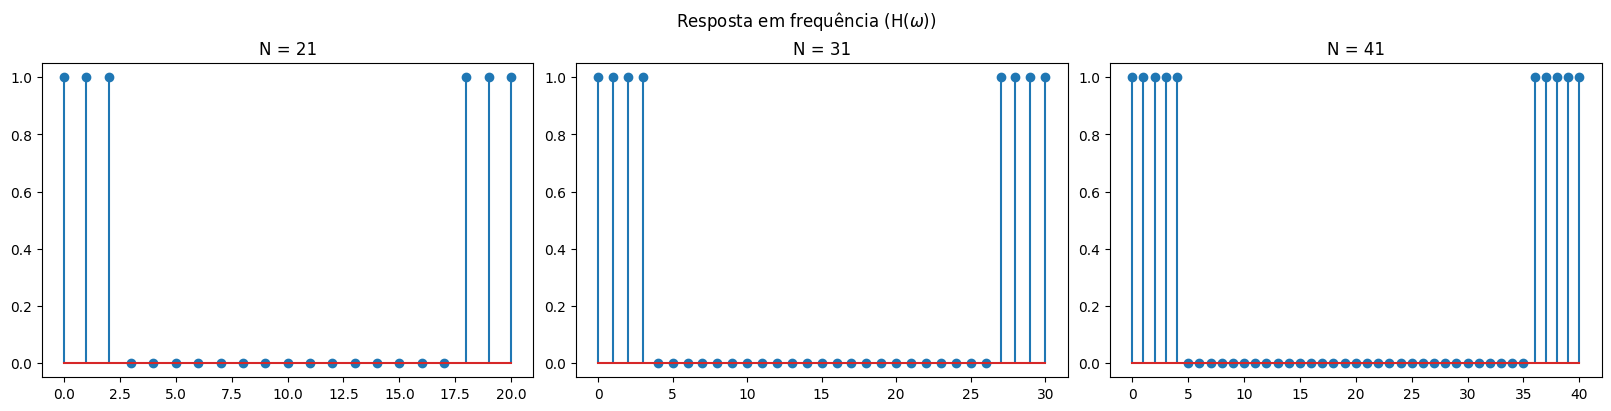

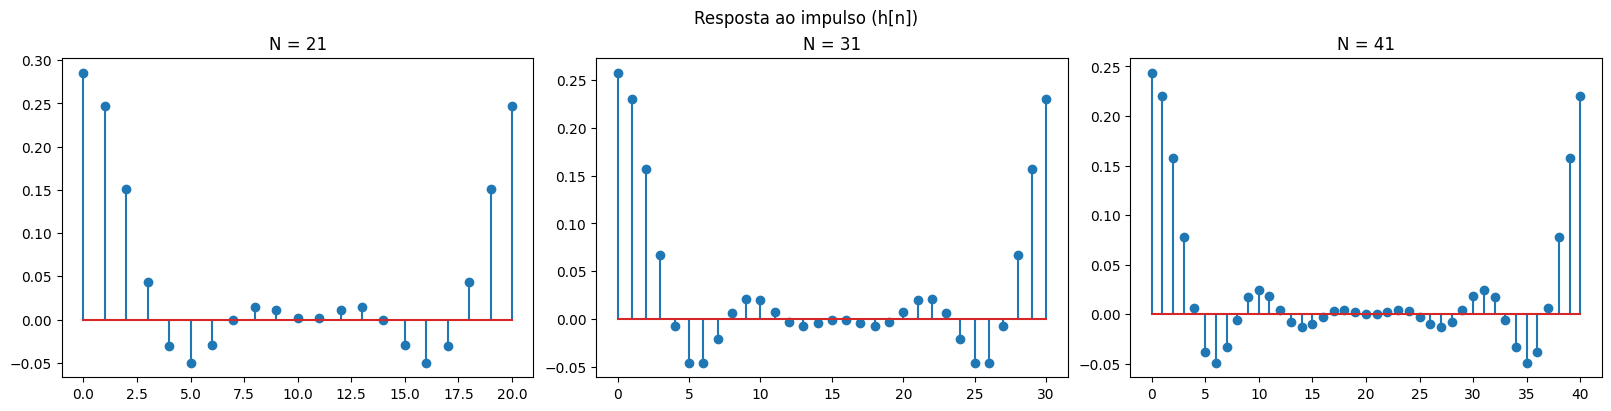

In [11]:
def h(x: np.ndarray) -> np.ndarray:
    length = len(x)
    response = np.zeros(length)
    for i in range(length):
        if x[i] <= np.pi/5 or x[i] >= 2*np.pi-np.pi/5:
            response[i] = 1
    return response


N = [21, 31, 41]
# Resposta em frequência
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), layout='constrained')
fig.suptitle('Resposta em frequência (H($\omega$))')
for i in range(len(N)):
    w = np.linspace(0, 2*np.pi, N[i])
    h_w = h(w)
    ax[i].stem(np.real(h_w))
    plt.setp(ax[i], title=f'N = {N[i]}')
plt.show()
# Resposta ao impulso
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), layout='constrained')
fig.suptitle('Resposta ao impulso (h[n])')
for i in range(len(N)):
    w = np.linspace(0, 2*np.pi, N[i])
    h_w = h(w)
    h_n = sp.fftpack.ifft(h_w)
    ax[i].stem(np.real(h_n))
    plt.setp(ax[i], title=f'N = {N[i]}')
plt.show()


A transformada de Fourier inversa da função $ret$ é a função $sinc$, mas fica clara a presença de aliasing na resposta ao impulso $h[n]$.

## Questão 3b (1.0  ponto)

A resposta ao impulso do filtro do item anterior deveria ser uma função *sinc*, que é uma função com suporte infinito. Porém, a amostragem amostra apenas a parte para $n$ positivo, gerando uma descontinuidade e uma resposta em frequência mais pobre. Uma forma de melhorar essa amostragem é centralizar a função *sinc* - para isso, devemos multiplicar a resposta em frequência do filtro $H\left(\Omega\right)$ por $e^{-j \Omega \frac{\left(N - 1\right)}{2}}$. Utilize essa técnica para gerar novos filtros com $N = 21$, $N = 31$ e $N = 41$. Compare os filtros com os filtros do item anterior com o mesmo tamanho.

Amostraremos até antes de 1 período, ou seja, $2\pi \Big(\frac{N-1}{N}\Big)$, para não haver interferência.

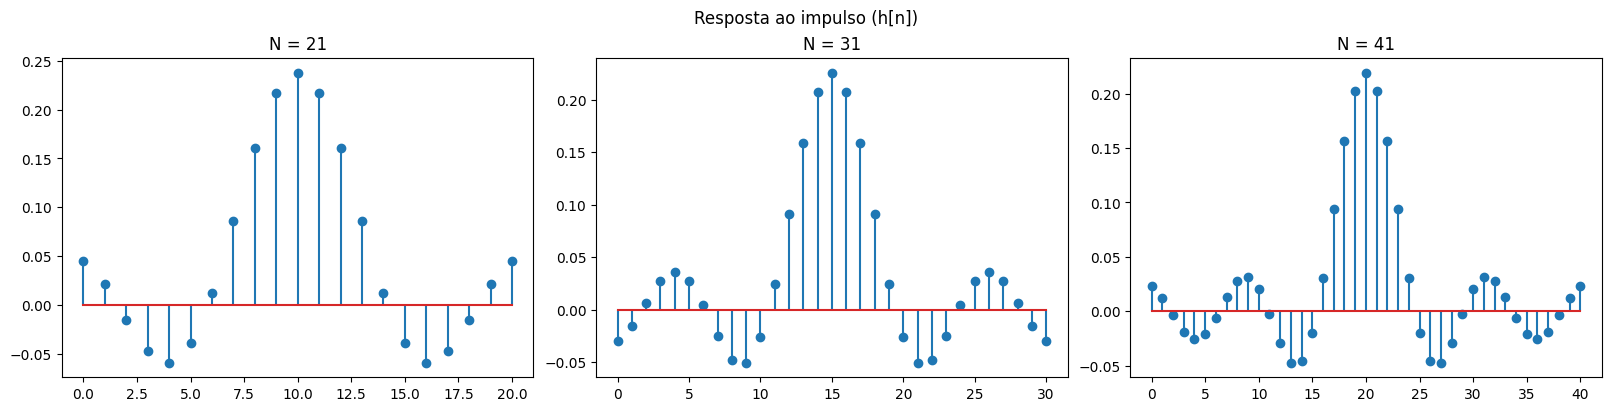

In [12]:
# Resposta ao impulso
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), layout='constrained')
fig.suptitle('Resposta ao impulso (h[n])')
for i in range(len(N)):
    stop = 2*np.pi * ((N[i]-1)/N[i])
    w = np.linspace(start=0, stop=stop, num=N[i])
    h_w = h(w) * np.exp(-1j*(N[i]-1)/2*w)
    h_n = sp.fftpack.ifft(h_w)
    ax[i].stem(np.real(h_n))
    plt.setp(ax[i], title=f'N = {N[i]}')
plt.show()

Através da comparação entre cada gráfico dessa questão e seu respectivo gráfico da questão anterior, fica notória a similaridade do novo gráfico com o gráfico de uma função $sinc$, algo que não acontecia claramente no $h[n]$ da questão anterior. Como a função $sinc$ é uma função com suporte infinito, a operação feita amenizou esse problema e trouxe uma melhor resposta em frequência.

## Questão 3c (1.0  ponto)

Aplique o filtro com $N = 41$ no sinal do arquivo "noisy\_ecg\_data\_3.mat". Compare o sinal de entrada com o sinal de saída. O que acontece com os picos do ECG? 

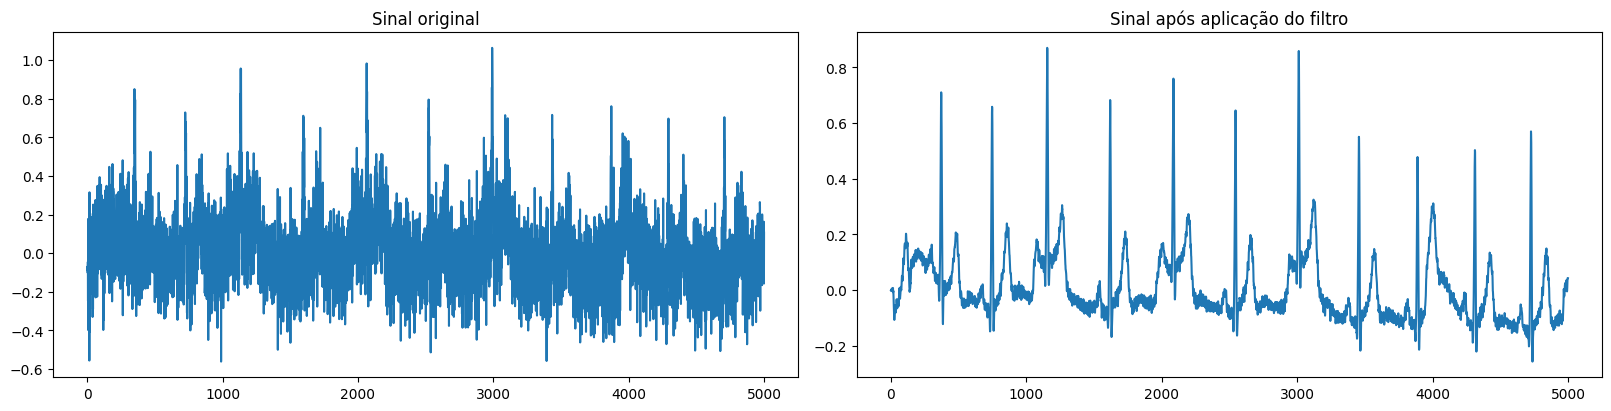

In [13]:
signal = sp.io.loadmat('noisy_ecg_data_3.mat')['noisy_ecg_3'].ravel()

stop = 2*np.pi * ((41-1)/41)
w = np.linspace(start=0, stop=stop, num=41)
h_w = h(w) * np.exp(-1j*(41-1)/2*w)
h_n = sp.fftpack.ifft(h_w)

A = np.zeros(len(h_n))
A[0] = 1
response = sp.signal.lfilter(h_n, A, signal)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), layout='constrained')
ax[0].plot(signal)
plt.setp(ax[0], title=f'Sinal original')
ax[1].plot(np.real(response))
plt.setp(ax[1], title=f'Sinal após aplicação do filtro')
plt.show()


Comparando o sinal original com ele após a aplicação do filtro, notamos que foi filtrada uma certa interferência que antes havia no sinal, similar ao que aconteceu com a questão 1-d do Projeto 2 da matéria. Pela alta similaridade entre o que aconteceu nessa questão com o que aconteceu com a questão mencionada, eu diria até que construímos um filtro idêntico, ou seja, eliminamos um ruído em uma determinada frequência.

## Questão 3d (1.0  ponto)

Utilize a técnica de *zero-phase filtering* com o filtro do item anterior. Compare a saída do sistema com e sem a aplicação da técnica.

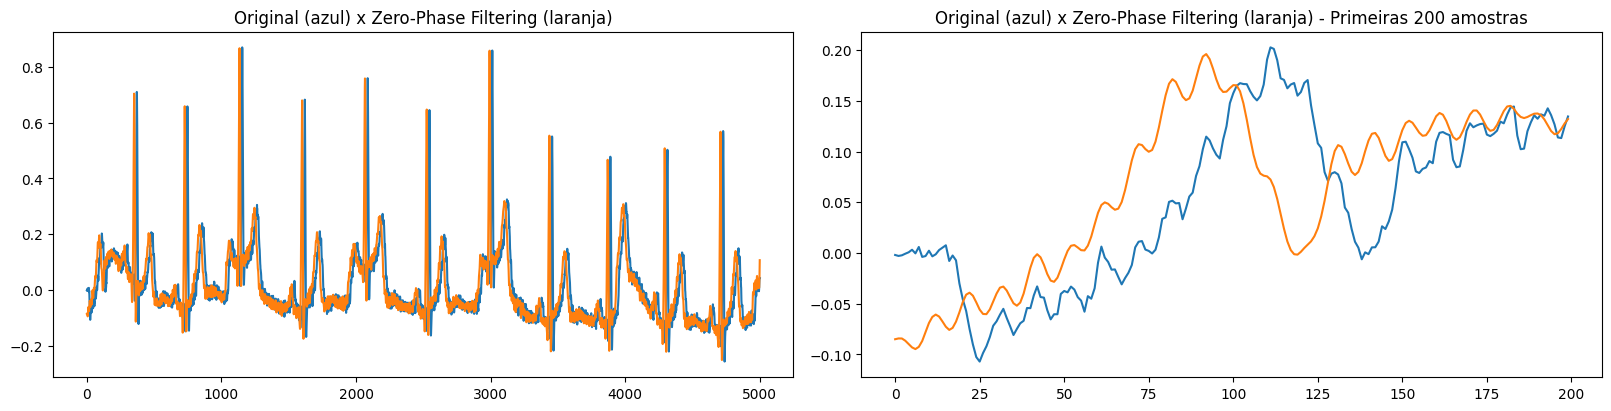

In [14]:
response_zpf = sp.signal.filtfilt(h_n, A, signal) # Função do SciPy para Zero-Phase Filtering

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), layout='constrained')
ax[0].plot(np.real(response))
ax[0].plot(np.real(response_zpf))
plt.setp(ax[0], title='Original (azul) x Zero-Phase Filtering (laranja)')
ax[1].plot(np.real(response)[:200])
ax[1].plot(np.real(response_zpf)[:200])
plt.setp(ax[1], title='Original (azul) x Zero-Phase Filtering (laranja) - Primeiras 200 amostras')
plt.show()

Usando o gráfico que analisa somente as 200 primeiras amostras para facilitar a compreensão visual, notamos principalmente a diferença de fase entre os dois gráficos. A técnica de Zero-Phase Filtering também altera a ordem e magnitude do filtro.